Importing what I may use and reading the data

In [423]:
import pandas as pd
import numpy as np
import sklearn as skl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn import tree
from math import log
import datetime

In [424]:
df = pd.read_csv('employee_retention_data.csv')

Let's take a look at the features

In [425]:
list(df)

['employee_id',
 'company_id',
 'dept',
 'seniority',
 'salary',
 'join_date',
 'quit_date']

And now let's do some EDA

In [426]:
df.shape

(24702, 7)

(array([9.272e+03, 9.092e+03, 6.336e+03, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([ 1. , 10.8, 20.6, 30.4, 40.2, 50. , 59.8, 69.6, 79.4, 89.2, 99. ]),
 <a list of 10 Patch objects>)

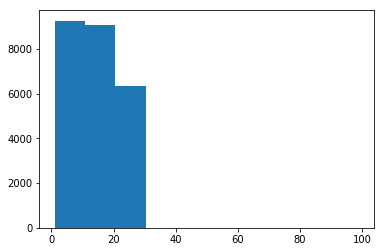

In [427]:
plt.hist(df.seniority)

(array([2886., 5511., 5388., 3614., 3098., 1788., 1151.,  963.,  286.,
          17.]),
 array([ 17000.,  56100.,  95200., 134300., 173400., 212500., 251600.,
        290700., 329800., 368900., 408000.]),
 <a list of 10 Patch objects>)

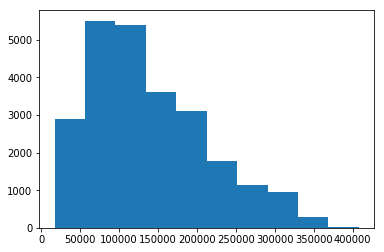

In [428]:
plt.hist(df.salary)

In [429]:
df.groupby('dept')['employee_id'].count()

dept
customer_service    9180
data_science        3190
design              1380
engineer            4613
marketing           3167
sales               3172
Name: employee_id, dtype: int64

In [430]:
df.groupby('company_id')['employee_id'].count()

company_id
1     8486
2     4222
3     2749
4     2062
5     1755
6     1291
7     1224
8     1047
9      961
10     865
11      16
12      24
Name: employee_id, dtype: int64

Want to know how many people quit

In [431]:
df.quit_date.isna().sum()

11192

So the percent of people who were hired and quit is

In [432]:
1 - df.quit_date.isna().sum()/df.employee_id.count()

0.5469192777912719

Since every row has an employee id (see below)

In [351]:
df.employee_id.isna().sum()

0

The classes of quit vs. not quit are pretty balanced if 45% have quit and 55% have not

Converting the dates to datetime format

In [352]:
df.join_date = pd.to_datetime(df.join_date)

In [353]:
df.quit_date = pd.to_datetime(df.quit_date)

(array([2450., 2485., 2621., 2383., 2544., 2346., 2582., 2337., 2471.,
        2483.]),
 array([734161. , 734339.1, 734517.2, 734695.3, 734873.4, 735051.5,
        735229.6, 735407.7, 735585.8, 735763.9, 735942. ]),
 <a list of 10 Patch objects>)

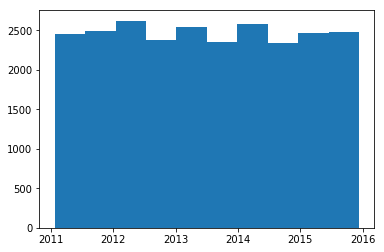

In [354]:
plt.hist(df.join_date)

(array([ 268.,  757.,  866., 1308., 1347., 1476., 1574., 1917., 2021.,
        1976.]),
 array([734423. , 734574.8, 734726.6, 734878.4, 735030.2, 735182. ,
        735333.8, 735485.6, 735637.4, 735789.2, 735941. ]),
 <a list of 10 Patch objects>)

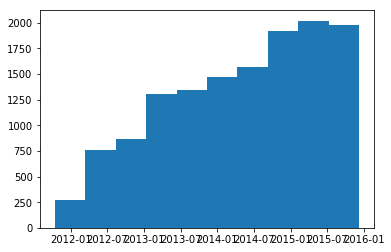

In [356]:
plt.hist(df.quit_date[~df.quit_date.isna()])

Want to know how long they had the job before they quit

In [357]:
df['job_length'] = df.quit_date - df.join_date

Now converting this to just how many days it is.

In [358]:
sec = lambda t: t.total_seconds() 
df.job_length = df.job_length.map(sec)/(60*60*24)

In [359]:
df.job_length.max()

1726.0

I decided that, in order to understand employee churn, I should try to predict IF someone will quit and what features are the most important for that classification. Ultimately, I would like to predict WHEN that would be. Perhaps after deciding someone would quit using a classification algorithm I could try to predict when it would be using a regressor? This may need to wait.

Dealing with the data a little more:

I noticed the seniority was very skewed, so let's look at the max values

In [360]:
sorted(df.seniority)[-10:]

[29, 29, 29, 29, 29, 29, 29, 29, 98, 99]

Values of 98 or 99 don't make sense, so let's remove them

In [361]:
df = df[df.seniority < 50]

In [362]:
df.shape

(24700, 8)

(array([2684., 2781., 2880., 2839., 1814., 2740., 2626., 2331., 2152.,
        1853.]),
 array([ 1. ,  3.8,  6.6,  9.4, 12.2, 15. , 17.8, 20.6, 23.4, 26.2, 29. ]),
 <a list of 10 Patch objects>)

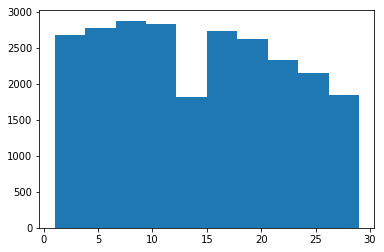

In [363]:
plt.hist(df.seniority)

That looks a lot better! I would also like it if the salary were more normal

(array([2886., 5511., 5388., 3614., 3097., 1788., 1150.,  963.,  286.,
          17.]),
 array([ 17000.,  56100.,  95200., 134300., 173400., 212500., 251600.,
        290700., 329800., 368900., 408000.]),
 <a list of 10 Patch objects>)

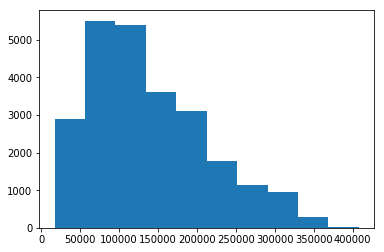

In [364]:
plt.hist(df.salary)

(array([ 819., 1108., 2292., 3577., 4815., 3998., 3887., 2313., 1634.,
         257.]),
 array([25.71281591, 30.55839385, 35.4039718 , 40.24954975, 45.0951277 ,
        49.94070565, 54.78628359, 59.63186154, 64.47743949, 69.32301744,
        74.16859539]),
 <a list of 10 Patch objects>)

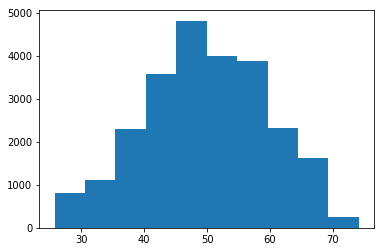

In [365]:
plt.hist(df.salary**(1/3))

That's a little better. Let's make it official:

In [366]:
df.salary = df.salary**(1/3)

Now let's scale salary and seniority

In [367]:
sal_mean = df.salary.mean()
sal_std = df.salary.std()
sen_mean = df.seniority.mean()
sen_std = df.seniority.std()

In [368]:
print('sal_mean: {}, sal_std: {}, sen_mean: {}, sen_std: {}'.format(sal_mean, sal_std, sen_mean, sen_std))

sal_mean: 49.851674699458314, sal_std: 9.801621996433013, sen_mean: 14.120971659919029, sen_std: 8.0541371816683


Let's scale these values and then plot/look at

In [369]:
df.salary = (df.salary - sal_mean)/sal_std

In [370]:
df.seniority = (df.seniority - sen_mean)/sen_std

(array([ 819., 1108., 2292., 3577., 4815., 3998., 3887., 2313., 1634.,
         257.]),
 array([-2.46274125, -1.96837634, -1.47401143, -0.97964653, -0.48528162,
         0.00908329,  0.50344819,  0.9978131 ,  1.49217801,  1.98654292,
         2.48090782]),
 <a list of 10 Patch objects>)

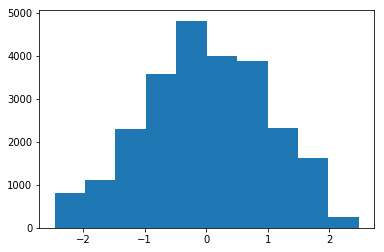

In [371]:
plt.hist(df.salary)

(array([2684., 2781., 2880., 2839., 2725., 1829., 2626., 2331., 2152.,
        1853.]),
 array([-1.62909712, -1.2814497 , -0.93380228, -0.58615486, -0.23850744,
         0.10913998,  0.45678739,  0.80443481,  1.15208223,  1.49972965,
         1.84737707]),
 <a list of 10 Patch objects>)

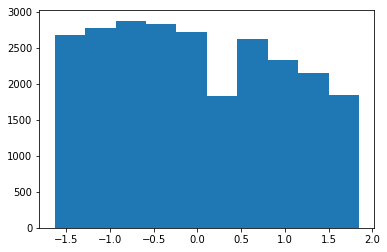

In [372]:
plt.hist(df.seniority)

Alright, those are in a comparable range now!

Let's start applying some machine learning algorithms.

I will look at the F1 score. I am interested in the recall, because I want to make sure the people who quit are identified. However, I do not want to predict that everyone will quit, so I will use F1.

Adding the T/F quit feature

In [373]:
df['quit_job'] = ~df.quit_date.isna()

In [374]:
bigdf = df #in case I want this later

In [375]:
list(df)

['employee_id',
 'company_id',
 'dept',
 'seniority',
 'salary',
 'join_date',
 'quit_date',
 'job_length',
 'quit_job']

In [376]:
df = df.drop(columns = ['employee_id', 'join_date',
 'quit_date',
 'job_length'])

In [377]:
list(df)

['company_id', 'dept', 'seniority', 'salary', 'quit_job']

The first time I did this, I did not get dummies for the company id. I am doing that now!

In [378]:
type(df.company_id.iloc[12])

numpy.int64

In [379]:
df.company_id = df.company_id.map(str)

In [380]:
type(df.company_id.iloc[12])

str

In [381]:
df = pd.get_dummies(df, drop_first = True)

In [382]:
list(df)

['seniority',
 'salary',
 'quit_job',
 'company_id_10',
 'company_id_11',
 'company_id_12',
 'company_id_2',
 'company_id_3',
 'company_id_4',
 'company_id_5',
 'company_id_6',
 'company_id_7',
 'company_id_8',
 'company_id_9',
 'dept_data_science',
 'dept_design',
 'dept_engineer',
 'dept_marketing',
 'dept_sales']

In [383]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = ['quit_job']), df.quit_job, test_size=0.2, random_state = 0)

First, **Logistic Regression**

In [384]:
best_F1 = 0
best_solver = ''
best_LogReg = ''
best_pen = ''
for s in ['newton-cg', 'lbfgs', 'sag']:
    clf = skl.linear_model.LogisticRegression(penalty = 'l2', solver = s).fit(X_train, y_train)
    F1 = skl.metrics.f1_score(y_test, clf.predict(X_test))
    print('F1 score of {} for solver {} with penalty {}'.format(F1, s, 'l2'))
    if F1 > best_F1:
        best_F1 = F1
        best_solver = s
        best_pen = 'l2'
        best_LogReg = clf
for s in ['liblinear', 'saga']:
    clf = skl.linear_model.LogisticRegression(penalty = 'l1', solver = s).fit(X_train, y_train)
    F1 = skl.metrics.f1_score(y_test, clf.predict(X_test))
    print('F1 score of {} for solver {} with penalty {}'.format(F1, s, 'l1'))
    if F1 > best_F1:
        best_F1 = F1
        best_solver = s
        best_pen = 'l1'
        best_LogReg = clf
print('The best logistic regression F1 score I found is {} for solver {} with penalty {}'.format(best_F1, best_solver, best_pen))
    

F1 score of 0.7002164502164503 for solver newton-cg with penalty l2
F1 score of 0.7002164502164503 for solver lbfgs with penalty l2
F1 score of 0.7002164502164503 for solver sag with penalty l2
F1 score of 0.7010671349452925 for solver liblinear with penalty l1
F1 score of 0.7008916509051607 for solver saga with penalty l1
The best logistic regression F1 score I found is 0.7010671349452925 for solver liblinear with penalty l1


The F1 scores are all pretty comparable, but I will go with the largest (by a little)

Need a way to consider the feature importance

Let's consider another model. This time, random forest!

In [385]:
RFC_10 = RandomForestClassifier(n_estimators = 10).fit(X_train, y_train)
F1 = skl.metrics.f1_score(y_test, RFC_10.predict(X_test))
print('For random forest with 10 trees I have an F1 score of {}'.format(F1))
RFC_20 = RandomForestClassifier(n_estimators = 20).fit(X_train, y_train)
F1 = skl.metrics.f1_score(y_test, RFC_20.predict(X_test))
print('For random forest with 20 trees I have an F1 score of {}'.format(F1))

For random forest with 10 trees I have an F1 score of 0.5495529061102832
For random forest with 20 trees I have an F1 score of 0.5608058608058608


In [386]:
RFC_50 = RandomForestClassifier(n_estimators = 50).fit(X_train, y_train)
F1 = skl.metrics.f1_score(y_test, RFC_50.predict(X_test))
print('For random forest with 50 trees I have an F1 score of {}'.format(F1))

For random forest with 50 trees I have an F1 score of 0.560757879395154


In [387]:
RFC_100 = RandomForestClassifier(n_estimators = 100).fit(X_train, y_train)
F1 = skl.metrics.f1_score(y_test, RFC_100.predict(X_test))
print('For random forest with 100 trees I have an F1 score of {}'.format(F1))

For random forest with 100 trees I have an F1 score of 0.5555959302325582


So, RFC_100 is my best random forest, but it is not as good as my logistic regression. I could also have done more hyperparameter tuning.

Let's look at decision trees now. Should I have done trees before forests? Probably!

In [388]:
T = tree.DecisionTreeClassifier().fit(X_train, y_train)
F1 = skl.metrics.f1_score(y_test, T.predict(X_test))
print('For the default decision tree, I have an F1 score of {}'.format(F1))

For the default decision tree, I have an F1 score of 0.5282071097372488


I guess it makes sense that the decision tree wouldn't be as good as a random forest.

Let's look at one more classifier: SVM.

I'll play with a few parameters, but I'm not doing cross-validation (I know I should)

In [389]:
S = skl.svm.SVC().fit(X_train, y_train)
F1 = skl.metrics.f1_score(y_test, S.predict(X_test))
print('For the default SVM, I have an F1 score of {}'.format(F1))

/Users/rebeccamoran/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For the default SVM, I have an F1 score of 0.7027102154273802


In [390]:
best_F1 = 0
best_C = -1
best_deg = -1
for my_C in range(1,5):
    for deg in range(1,5):
        S = skl.svm.SVC(C = my_C, degree = deg, gamma = 'auto').fit(X_train, y_train) 
        # gamma = 'auto' to prevent warning from printing
        F1 = skl.metrics.f1_score(y_test, S.predict(X_test))
        print('For SVC with C = {} and degree {}, I have an F1 score of {}'.format(my_C, deg, F1))
        if F1 < best_F1:
            best_F1 = F1
            best_C = my_C
            best_deg = deg
            best_SVC = S
    

For SVC with C = 1 and degree 1, I have an F1 score of 0.7027102154273802
For SVC with C = 1 and degree 2, I have an F1 score of 0.7027102154273802
For SVC with C = 1 and degree 3, I have an F1 score of 0.7027102154273802
For SVC with C = 1 and degree 4, I have an F1 score of 0.7027102154273802
For SVC with C = 2 and degree 1, I have an F1 score of 0.7027627377481603
For SVC with C = 2 and degree 2, I have an F1 score of 0.7027627377481603
For SVC with C = 2 and degree 3, I have an F1 score of 0.7027627377481603
For SVC with C = 2 and degree 4, I have an F1 score of 0.7027627377481603
For SVC with C = 3 and degree 1, I have an F1 score of 0.699665365309537
For SVC with C = 3 and degree 2, I have an F1 score of 0.699665365309537
For SVC with C = 3 and degree 3, I have an F1 score of 0.699665365309537
For SVC with C = 3 and degree 4, I have an F1 score of 0.699665365309537
For SVC with C = 4 and degree 1, I have an F1 score of 0.697943082558467
For SVC with C = 4 and degree 2, I have an 

I guess changing the degree didn't change anything. Well I'm keeping it here to show I tried adjusting parameters.

So, I'm done playing with models. The best F1 score I got BEFORE making the company_id categorical was  0.7074 for logistic regression with solver saga and penalty l1. The best score I got AFTER doing that was the default SVC.

Now I want to figure out what is contributing most to this model. First, for the logistic regression...

In [391]:
best_LogReg.coef_

array([[-2.90955482e-02,  4.90655779e-02,  1.07441931e-01,
         2.49048128e-01, -2.79984854e-02, -9.02661939e-02,
         7.73000159e-02,  9.72979247e-02,  1.06402242e-01,
         4.42731212e-02,  1.14382830e-01,  6.76525258e-02,
         3.30612871e-02, -1.71855573e-01,  1.20432197e-02,
        -2.49704042e-01, -2.59351614e-02, -1.12696046e-04]])

In [392]:
list(df)

['seniority',
 'salary',
 'quit_job',
 'company_id_10',
 'company_id_11',
 'company_id_12',
 'company_id_2',
 'company_id_3',
 'company_id_4',
 'company_id_5',
 'company_id_6',
 'company_id_7',
 'company_id_8',
 'company_id_9',
 'dept_data_science',
 'dept_design',
 'dept_engineer',
 'dept_marketing',
 'dept_sales']

In [393]:
df.std()

seniority            1.000000
salary               1.000000
quit_job             0.497807
company_id_10        0.183732
company_id_11        0.025444
company_id_12        0.031157
company_id_2         0.376456
company_id_3         0.314504
company_id_4         0.276615
company_id_5         0.256918
company_id_6         0.222570
company_id_7         0.217027
company_id_8         0.201478
company_id_9         0.193377
dept_data_science    0.335372
dept_design          0.229676
dept_engineer        0.389695
dept_marketing       0.334295
dept_sales           0.334565
dtype: float64

In [394]:
best_LogReg.coef_[0]*df.drop(columns = ['quit_job']).std()

seniority           -0.029096
salary               0.049066
company_id_10        0.019741
company_id_11        0.006337
company_id_12       -0.000872
company_id_2        -0.033981
company_id_3         0.024311
company_id_4         0.026914
company_id_5         0.027337
company_id_6         0.009854
company_id_7         0.024824
company_id_8         0.013631
company_id_9         0.006393
dept_data_science   -0.057636
dept_design          0.002766
dept_engineer       -0.097308
dept_marketing      -0.008670
dept_sales          -0.000038
dtype: float64

In [398]:
sum([0.006337,
0.000872,
0.033981,
0.024311,
0.026914,
0.027337,
0.009854,
0.024824,
0.013631,
0.006393])

0.17445400000000003

The internet makes it sound like a coeffiecient times the std dev of the feature is related to feature importance. If so, it seems like the company has a big influcence on quitting (if you sum the absolute values, as above), and working in DS or DE influences you not to quit. Salary also has an impact.

**Questions/Answers BASED ON WORK SO FAR** 
* _What are the main factors that drive employee churn? Do they make sense? Explain your findings._

It appears the main factors that drive employee churn are where they work (company), their salary, and if they work in DS or DE (this seems to mean they don't quit). Since salary has a positive coefficient, does that mean an employee with a higher salary is more likely to quit?


* _What might you be able to do for the company to address employee Churn, what would be follow-up actions?_

There are different companies, aren't there? Are they sub-companies?


* _If you could add to this data set just one variable that could help explain employee churn, what would that be?_

I would like a variable of the reason an employee gives for leaving. This could be in the form of a survey, or we could use NLP. There may be something we are not considering


**Other notes**

I would have liked to:
* Combine features
* Hyperparameter tuning with cross validation
* Regression. Is that actualy what this problem is about?

I don't think this model is actually good, by the way. Look at what it predicts for the test set:

In [399]:
best_LogReg.predict(X_test).sum()

4697

In [400]:
X_test.shape

(4940, 18)

It predicts almost everyone as quitting!

NOTE TO FUTURE ME: I will need to read through everything and make sure what I wrote makes sense!

**BUT WAIT, there's more!**
So, I heard someone say they didn't even use a model, so now I'm going to just do some more EDA and see how the quit/didn't quit populations differ

Going back to the original df before I scaled some features

In [406]:
origdf = pd.read_csv('employee_retention_data.csv')

In [408]:
origdf['quit_job'] = ~origdf.quit_date.isna()

In [448]:
origdf = origdf[df.seniority < 50]

More EDA time!

In [450]:
origdf[origdf.quit_job == 1].salary.mean()

135639.1027539236

In [451]:
origdf[origdf.quit_job == 0].salary.mean()

141238.47390993568

In [452]:
origdf[origdf.quit_job == 1].salary.median()

122000.0

In [453]:
origdf[origdf.quit_job == 0].salary.median()

123000.0

In [454]:
origdf[origdf.quit_job == 1].seniority.mean()

14.118966538347646

In [455]:
origdf[origdf.quit_job == 0].seniority.mean()

14.123391708363117

In [456]:
origdf[origdf.quit_job == 1].seniority.median()

14.0

In [457]:
origdf[origdf.quit_job == 0].seniority.median()

14.0

Now, I would like to do hypothesis testing, but my first instinct is that these aren't very different (definitely for seniority)

Okay, let's try a hypothesis test in Python for comparing the salaries...

In [459]:
np.std(origdf[origdf.quit_job == 0].salary)

81174.56552847162

In [460]:
np.std(origdf[origdf.quit_job == 1].salary)

71436.42619012341

In [461]:
from scipy import stats

In [462]:
t, p = stats.ttest_ind(origdf[origdf.quit_job == 1].salary, origdf[origdf.quit_job == 0].salary, equal_var=False)

In [463]:
print(t)

-5.695229621683827


In [464]:
print(p)

1.2474275862013815e-08


Okay, that's a small p-value! So it seems we can reject the null hypothesis that the two populations (quit and not quit) have identical mean salaries.

So, it looks like the people who quit had lower salaries, so I'm thinking that's a contributor to why they quit. Using statistics but not machine learning.

Now let's look at the salary divided by seniority (dollars per year of experience). Order: mean (quit, not quit), median (quit, not quit), std dev (quit, not quit)

In [470]:
(origdf[origdf.quit_job == 1].salary/origdf[origdf.quit_job == 1].seniority).mean()

12731.507250500646

In [471]:
(origdf[origdf.quit_job == 0].salary/origdf[origdf.quit_job == 0].seniority).mean()

13064.427990716422

In [472]:
(origdf[origdf.quit_job == 1].salary/origdf[origdf.quit_job == 1].seniority).median()

10133.333333333334

In [473]:
(origdf[origdf.quit_job == 0].salary/origdf[origdf.quit_job == 0].seniority).median()

10609.903381642513

In [474]:
(origdf[origdf.quit_job == 1].salary/origdf[origdf.quit_job == 1].seniority).std()

9646.356682369775

In [475]:
(origdf[origdf.quit_job == 0].salary/origdf[origdf.quit_job == 0].seniority).std()

9833.27173421983

In [465]:
t, p = stats.ttest_ind(origdf[origdf.quit_job == 1].salary/origdf[origdf.quit_job == 1].seniority, origdf[origdf.quit_job == 0].seniority, equal_var=False)

In [466]:
print(p)

0.0


In [476]:
t, p = stats.ttest_ind(origdf[origdf.quit_job == 1].salary/origdf[origdf.quit_job == 1].seniority, origdf[origdf.quit_job == 0].seniority, equal_var=True)

In [478]:
print(p)

0.0


Okay, so whether or not the standard deviations are the same, we get a small p-value, so the population means are different.

That is, on average, the people who quit had a lower salary per year of experience than the people who didn't quit.

Below is what percent of employees from each company quit

In [482]:
origdf[origdf.quit_job == 1].groupby('company_id').employee_id.count()/origdf.groupby('company_id').employee_id.count()

company_id
1     0.544490
2     0.522501
3     0.556930
4     0.559166
5     0.560114
6     0.551510
7     0.565359
8     0.553009
9     0.550468
10    0.554398
11    0.750000
12    0.500000
Name: employee_id, dtype: float64

It looks like a lot of employees in company 11 are quitting, but it's not a large company (it only has 16 employees):

In [485]:
origdf[origdf.company_id == 11].employee_id.count()

16

Below is the percent that quit by department

In [486]:
origdf[origdf.quit_job == 1].groupby('dept').employee_id.count()/origdf.groupby('dept').employee_id.count()

dept
customer_service    0.554902
data_science        0.527273
design              0.563768
engineer            0.511925
marketing           0.562855
sales               0.570933
Name: employee_id, dtype: float64

Now I should look into this more, but I've already written a lot and I need to stop soon.

**Questions/Answers UPDATED** 
* _What are the main factors that drive employee churn? Do they make sense? Explain your findings._

Employees who quit have lower salaries and a lower salary per year of experience than those who did not quit. This makes sense. If someone feels undervalued at a company, they may feel encouraged to quit and find a new job.


* _What might you be able to do for the company to address employee Churn, what would be follow-up actions?_

Make the salaries more standardized.


* _If you could add to this data set just one variable that could help explain employee churn, what would that be?_

Same as before: I would like a variable of the reason an employee gives for leaving. This could be in the form of a survey, or we could use NLP. There may be something we are not considering